In [1]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
data=pd.read_csv('../cs230a/data/train.csv')
test_data = pd.read_csv('../cs230a/data/test.csv')
data.head(5)

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


Select the data sample

In [2]:
landmark_list = [str(x) for x in list(range(2000,2050))]
data_sample = data[data['landmark_id'].isin(landmark_list)]
data_sample.landmark_id.value_counts()

2037    112
2046     80
2011     69
2029     47
2015     45
2003     41
2021     40
2030     28
2042     27
2016     27
2012     26
2040     25
2049     23
2047     21
2048     21
2044     20
2022     15
2026     14
2020     13
2004     13
2010     11
2019     11
2032     11
2043      8
2013      8
2039      8
2007      7
2045      7
2041      7
2014      6
2036      5
2038      5
2035      5
2005      5
2006      5
2031      3
2034      3
2008      3
2000      2
2001      2
2024      2
2025      2
2018      2
2028      1
2023      1
2033      1
2002      1
2017      1
2027      1
2009      1
Name: landmark_id, dtype: int64

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


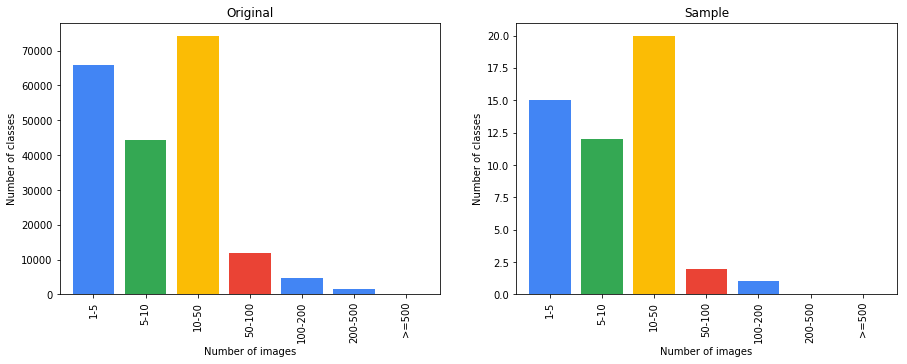

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)

In [4]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df




In [5]:
data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')
'''Split to test and train'''
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.1 #takes 10% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_sample['landmark_id']):
    n=1
    t = data_sample[(data_sample.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample[data_sample.id.isin(test)] #holdout dataset
    data_tr = data_sample[data_sample.id.isin(training)] #training dataset
    data_test = data_test.append(data_t)  
    data_training_all = data_training_all.append(data_tr)
    n+=1

print ('2. train and test set created')

1. URLs overwritten
2. train and test set created


In [6]:
data_training_all.landmark_id.value_counts()

2037    101
2046     72
2011     63
2029     43
2015     41
2003     37
2021     36
2030     26
2042     25
2016     25
2012     24
2040     23
2049     21
2047     19
2048     19
2044     18
2022     14
2026     13
2020     12
2004     12
2010     10
2019     10
2032     10
2043      8
2013      8
2039      8
2007      7
2045      7
2041      7
2014      6
2036      5
2038      5
2035      5
2005      5
2006      5
2031      3
2034      3
2008      3
2000      2
2001      2
2024      2
2025      2
2018      2
2028      1
2023      1
2033      1
2002      1
2017      1
2027      1
2009      1
Name: landmark_id, dtype: int64

In [7]:
'''Split into train and validation set'''
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')

3. train and validation set created


In [8]:
print (len(data_train))
print (len(data_valid))
print (len(data_test))

638
138
66


In [9]:
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    with open('../cs230a/data/' + folder + '/image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
    
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
i=0
for link in data_train['url']:              #looping over links to get images
    if os.path.exists('../cs230a/data/train_images_model/'+str(data_train['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'train_images_model')
    os.rename('../cs230a/data/train_images_model/image.jpg','../cs230a/data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
    i+=1
#if(i==50):   #uncomment to test in your machine
# break
print('4. train images fetched')

    
i=0
for link in data_valid['url']:              #looping over links to get images
    if os.path.exists('../cs230a/data/validation_images_model/'+str(data_valid['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'validation_images_model')
    os.rename('../cs230a/data/validation_images_model/image.jpg','../cs230a/data/validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine
#         break
print('5. Validation images fetched')

i=0
for link in data_test['url']:              #looping over links to get images
    if os.path.exists('../cs230a/data/test_images_from_train/'+str(data_test['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'test_images_from_train')
    os.rename('../cs230a/data/test_images_from_train/image.jpg','../cs230a/data/test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine
#         break
print('6. Test images fetched')

4. train images fetched
5. Validation images fetched
6. Test images fetched


In [10]:
##create folders for landmark IDs in Training folder
import pandas as pd
import os
import shutil
from shutil import copyfile
import urllib

train_data = data_train

temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = '../cs230a/data/' + folder + '/'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1
createfolders(temp,'train_images_model')
print ('Train folders created')

Train folders created


In [11]:
rootdirpics = r'../cs230a/data/train_images_model/'
rootdirfolders = r'../cs230a/data/train_images_model/'
def transformdata(data,path1, path2):

    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >2000)):
#                 print('move')
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 2000)):
                os.remove(inpath)
        n+=1

transformdata(train_data,rootdirpics, rootdirfolders)
print ('Train images moved')

Train images moved


In [12]:
#create folders for landmark IDs in Validation folder

temp = pd.DataFrame(data_valid.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
createfolders(temp,'validation_images_model')
print ('Validation folders created')

#make folders for landmark ID which had no images in validation sets - required for codes running next
available = [int((x[0].split('/'))[-1]) for x in os.walk(r'../cs230a/data/validation_images_model/') if len((x[0].split('/'))[-1]) > 0]
#available = [int((x[0].split('/'))[-1]) for x in os.walk(r'../cs230a/data/validation_images_model/') if len((x[0].split('/'))[-1]) > 0]
new = [str(x) for x in range(2000,2050) if x not in available]
for i in new:
    path = '../cs230a/data/validation_images_model/' + i
    if not os.path.exists(path):
        os.makedirs(path)

rootdirpics = r'../cs230a/data/validation_images_model/'
rootdirfolders = r'../cs230a/data/validation_images_model/'
transformdata(data_valid,rootdirpics, rootdirfolders)
print ('Validation images moved')

Validation folders created
Validation images moved


In [ ]:
#Display Image

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 

def displayLandmarkImagesLarge(urls, category_name):
    img_style = "width: 200px; height:160px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

category = data['landmark_id'].value_counts().keys()[15]
urls = data[data['landmark_id'] == category]['url']
displayLandmarkImagesLarge(urls, "")

In [14]:
# Visualize 6 images for each of the first 4 landmarks, ordered by the number of occurences.
LANDMARK_NUMBER = 4
IMAGES_NUMBER = 6
landMarkIDs = pd.Series(data['landmark_id'].value_counts().keys())[0:LANDMARK_NUMBER]
for landMarkID in landMarkIDs:
    url = data[data['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url, "")

In [15]:
pd.Series(data['landmark_id'].value_counts().keys())[1:4]

1     62798
2    177870
3    176528
dtype: int64

Download the weights from ImageNet

In [125]:
#Predictions using weights from ImageNet
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model =VGG16(weights = 'imagenet', include_top = True)

img_path = r'../cs230a/data/train_images_model/2037/dd408099a4505a88.jpg'
img = image.load_img(img_path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top = 3)[0])

# 0a0667fc2436a04b = stupa (17%)
# 0b48dd3b81d5b6ba = triumphal_arch(25%)

Predicted: [('n09399592', 'promontory', 0.75176185), ('n09428293', 'seashore', 0.14711969), ('n09246464', 'cliff', 0.048021324)]


In [126]:
#Model Training -- Transfer Learning
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import csv
import os
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
import math
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import tensorflow as tf
import keras


#counts the number of files in subdirectories of a given directory. 
#outputs the count of images and label of each image in order of reading.


In [127]:
train_data_dir = '../cs230a/data/train_images_model'
validation_data_dir = '../cs230a/data/validation_images_model'

def count(dir):
    i = 2000
    count = []
    while i < 2050:
        f = str(i)
#         print (f)
        for root, dirs, files in os.walk(dir +'/'+ f):  # loop through startfolders
            for pic in files:
                count.append(f)  
                #print (i)
            i += 1
    print (len(count))
    return ([len(count),count])



In [131]:
nb_train_samples = count(train_data_dir)
nb_validation_samples = count(validation_data_dir)

629
138


In [134]:
#####MOVE a few photos to the moved folders

CL = '2037' #class from which to move images
NI = 1 

i = 0
for files in os.listdir(r'../cs230a/data/train_images_model/' + CL):    # loop through startfolders
            i+=1
            inpath = r'../cs230a/data/train_images_model/' + CL + '/' + files
            outpath = r'../cs230a/data/moved_images' 
            shutil.move(inpath, outpath)
            if i == NI:
                break

In [135]:
nb_train_samples = count(train_data_dir)
nb_validation_samples = count(validation_data_dir)

621
138


Importing the weights from ImageNet on VGG16

In [137]:
img_width, img_height = 96, 96 # dimensions of downloaded images.
top_model_weights_path = 'fc_model.h5' # A file with this name would be saved later in the code
epochs = 5
batch_size = 23

datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range = 0.5,
                                 brightness_range = [0.5,1.5])

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3))
print ('start')    
generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means our generator will only yield batches of data, no labels
        shuffle=False)
#     the predict_generator method returns the output of a model, given a generator that yields batches of numpy data
#print ('start2')
features_train = model.predict_generator(generator, nb_train_samples[0] // batch_size) 
print ('features_trained')

with open('features_train.npy', 'wb')as features_train_file:
        np.save(features_train_file, features_train)
print ('Train done')

datagen = ImageDataGenerator(rescale=1. / 255) #No image augmentation in validation dataset
generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
print ('validation predict start')
features_validation = model.predict_generator(generator, nb_validation_samples[0] // batch_size)
    
with open('features_validation.npy', 'wb') as features_validation_file:
        np.save(features_validation_file, bottleneck_features_validation)
print ('validation done')


start
Found 621 images belonging to 50 classes.
features_trained
Train done
Found 138 images belonging to 50 classes.
validation predict start
validation done


Initialize the weights on the top 4 layers

In [115]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])

In [141]:
epochs = 15
batch_size = 23 #990
import numpy as np
from tensorflow.keras.layers import MaxPooling2D

def train_top_model():
    train_data = np.load(open('features_train.npy', 'rb'))
    train_labels = np.array(nb_train_samples[1])
    train_labels = [str(int(train_label) - 2000) for train_label in train_labels] 
#Had to subtract 1000 because class labels should start from 0. In this case, class labels had a range from 1000 to 4999. 
#print (train_labels)
    validation_data = np.load(open('features_validation.npy', 'rb'))
    validation_labels = np.array(nb_validation_samples[1])
    validation_labels = [str(int(validation_label) - 2000) for validation_label in validation_labels]

#train_top_model()

    model = Sequential()
    #model.add(GlobalAveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten(input_shape=train_data.shape[1:]))
   
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.05))
    n_class = 50 #number of classes fed to the model
    model.add(Dense(n_class, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy'])
    train_labels = to_categorical(train_labels, n_class)
    validation_labels = to_categorical(validation_labels, n_class)
    print(model.summary())
    print ('model fit starting')
    model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
train_top_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dense_72 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 50)                12850     
Total params: 1,258,546
Trainable params: 1,258,546
Non-trainable params: 0
_________________________________________________________________
None
model fit starting
Train on 621 samples, validate on 138 samples
Epoch 1/15
621/621 [==============================] - 3s 5ms/s

Compile the entire model

In [143]:
img_width, img_height = 96, 96
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '../cs230a/data/train_images_model'
validation_data_dir = '../cs230a/data/validation_images_model'
batch_size = 23
epochs = 20
def trainCNN():

    # build the VGG16 network

    base_model = applications.VGG16(weights='imagenet',include_top= False,input_shape=(96,96,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.05))
    n_class = 50
    top_model.add(Dense(n_class, activation='softmax'))
    top_model.load_weights(top_model_weights_path) #Load the weights initialized in previous steps
    

    model = Model(input= base_model.input, output= top_model(base_model.output))
    model.summary
    # set the first 16 layers to non-trainable (weights will not be updated) - 1 conv layer and three dense layers will be trained
    for layer in model.layers[:16]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-8, decay=0.0),
                  metrics=['accuracy'])
    print ('Compilation done.')
    
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=90,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range = 0.5)
    
    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    np.save('class_indices.npy', train_generator.class_indices)

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    print ('Model fit begins...')
    model.fit_generator(
        train_generator,
        steps_per_epoch=40,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=15,
        callbacks=[ModelCheckpoint(filepath=top_model_weights_path, save_best_only=True, save_weights_only=True)]
        )
    
    model.save_weights(top_model_weights_path)

trainCNN()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


Compilation done.
Found 621 images belonging to 50 classes.
Found 138 images belonging to 50 classes.
Model fit begins...
Epoch 1/20
40/40 [==============================] - 243s 6s/step - loss: 3.8201 - acc: 0.0804 - val_loss: 3.2630 - val_acc: 0.1507
Epoch 2/20
40/40 [==============================] - 217s 5s/step - loss: 3.4446 - acc: 0.1022 - val_loss: 3.2992 - val_acc: 0.0928
Epoch 3/20
40/40 [==============================] - 222s 6s/step - loss: 3.4053 - acc: 0.1120 - val_loss: 3.1842 - val_acc: 0.2000
Epoch 4/20
40/40 [==============================] - 226s 6s/step - loss: 3.3624 - acc: 0.1196 - val_loss: 3.1928 - val_acc: 0.1507
Epoch 5/20
40/40 [==============================] - 224s 6s/step - loss: 3.2886 - acc: 0.1359 - val_loss: 3.0092 - val_acc: 0.2029
Epoch 6/20
40/40 [==============================] - 233s 6s/step - loss: 3.2467 - acc: 0.1598 - val_loss: 3.0208 - val_acc: 0.2203
Epoch 7/20
40/40 [==============================] - 224s 6s/step - loss: 3.2337 - acc: 0.152